# Explore here

It's recommended to use this notebook for exploration purposes.

In [1]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns



Había tenido un error 403 al principio. 
Cambiando el Header (User-Agent), obtuve un 200.

In [10]:
#Defino la función para obtener los datos de una web

def scrape_data(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    try:
        response = requests.get(url, headers=headers)
        time.sleep(2)  # Espera 2 segundos entre las solicitudes
        response.raise_for_status()  # Raises an HTTPError if the status is 4xx, 5xx

        #Instanciar BeatifulSoup y pasarle el texto HTML
        soup= BeautifulSoup(response.text, "html.parser")

        # Find all tables
        tables = soup.find_all("table")

        return tables
    
    #Excepciones:  
    except requests.exceptions.HTTPError as http_err:
        raise Exception(f"HTTP error occurred: {http_err}")  # Specific HTTP error
    
    except Exception as err:
        raise Exception(f"An error occurred: {err}")  # General error
    

url= "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
scrape_data(url)

[<table class="historical_data_table table">
 <thead>
 <tr>
 <th colspan="2" style="text-align:center">Tesla Annual Revenue<br/><span style="font-size:14px;">(Millions of US $)</span></th>
 </tr>
 </thead>
 <tbody>
 <tr>
 <td style="text-align:center">2023</td>
 <td style="text-align:center">$96,773</td>
 </tr>
 <tr>
 <td style="text-align:center">2022</td>
 <td style="text-align:center">$81,462</td>
 </tr>
 <tr>
 <td style="text-align:center">2021</td>
 <td style="text-align:center">$53,823</td>
 </tr>
 <tr>
 <td style="text-align:center">2020</td>
 <td style="text-align:center">$31,536</td>
 </tr>
 <tr>
 <td style="text-align:center">2019</td>
 <td style="text-align:center">$24,578</td>
 </tr>
 <tr>
 <td style="text-align:center">2018</td>
 <td style="text-align:center">$21,461</td>
 </tr>
 <tr>
 <td style="text-align:center">2017</td>
 <td style="text-align:center">$11,759</td>
 </tr>
 <tr>
 <td style="text-align:center">2016</td>
 <td style="text-align:center">$7,000</td>
 </tr>
 <

Pasar los datos obtenidos de la Web a una Pandas Data Frame         

In [14]:
import pandas as pd

tables = scrape_data(url)

# Buscar la tabla específica
table_index = -1
for index, table in enumerate(tables):
    if "Tesla Quarterly Revenue" in table.text:
        table_index = index
        break

if table_index == -1:
    raise Exception("No se encontró la tabla 'Tesla Quarterly Revenue' en la página.")

# Crear el DataFrame
tesla_revenue = pd.DataFrame(columns=["Date", "Revenue"])
rows = []
for row in tables[table_index].find_all("tr"):
    cols = row.find_all("td")
    if cols:
        Date = cols[0].text.strip()
        Revenue = cols[1].text.strip().replace("$", "").replace(",", "")
        rows.append({"Date": Date, "Revenue": Revenue})

tesla_revenue = pd.DataFrame(rows)
tesla_revenue["Revenue"] = pd.to_numeric(tesla_revenue["Revenue"])
tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"]).dt.strftime("%d-%m-%Y")

# Mostrar los primeros registros del DataFrame
tesla_revenue.head()

,Date,Revenue
0,31-03-2024,21301.0
1,31-12-2023,25167.0
2,30-09-2023,23350.0
3,30-06-2023,24927.0
4,31-03-2023,23329.0


Almacenar los datos en formato SQL

In [26]:
# Almacenar los datos en una base de datos SQLite
conn = sqlite3.connect("tesla_revenue.db")
cur = conn.cursor()

# Crear la tabla en la base de datos
cur.execute('''CREATE TABLE IF NOT EXISTS TeslaRevenue
               (Date TEXT, Revenue REAL)''')

# Insertar los datos en la tabla
for index, row in tesla_revenue.iterrows():
    cur.execute("INSERT INTO TeslaRevenue (Date, Revenue) VALUES (?, ?)", (row["Date"], row["Revenue"]))

# Guardar los cambios y cerrar la conexión
conn.commit()

print("Datos almacenados en la base de datos SQLite correctamente.")

#Ejecutar una consulta SQL en la tabla creada
for row in cur.execute("SELECT * FROM TeslaRevenue"):    
    print(row)

# Cerrar la conexión
conn.close()

Datos almacenados en la base de datos SQLite correctamente.
('31-03-2024', 21301.0)
('31-12-2023', 25167.0)
('30-09-2023', 23350.0)
('30-06-2023', 24927.0)
('31-03-2023', 23329.0)
('31-12-2022', 24318.0)
('30-09-2022', 21454.0)
('30-06-2022', 16934.0)
('31-03-2022', 18756.0)
('31-12-2021', 17719.0)
('30-09-2021', 13757.0)
('30-06-2021', 11958.0)
('31-03-2021', 10389.0)
('31-12-2020', 10744.0)
('30-09-2020', 8771.0)
('30-06-2020', 6036.0)
('31-03-2020', 5985.0)
('31-12-2019', 7384.0)
('30-09-2019', 6303.0)
('30-06-2019', 6350.0)
('31-03-2019', 4541.0)
('31-12-2018', 7226.0)
('30-09-2018', 6824.0)
('30-06-2018', 4002.0)
('31-03-2018', 3409.0)
('31-12-2017', 3288.0)
('30-09-2017', 2985.0)
('30-06-2017', 2790.0)
('31-03-2017', 2696.0)
('31-12-2016', 2285.0)
('30-09-2016', 2298.0)
('30-06-2016', 1270.0)
('31-03-2016', 1147.0)
('31-12-2015', 1214.0)
('30-09-2015', 937.0)
('30-06-2015', 955.0)
('31-03-2015', 940.0)
('31-12-2014', 957.0)
('30-09-2014', 852.0)
('30-06-2014', 769.0)
('31-03-2014

Visualización de Resultados

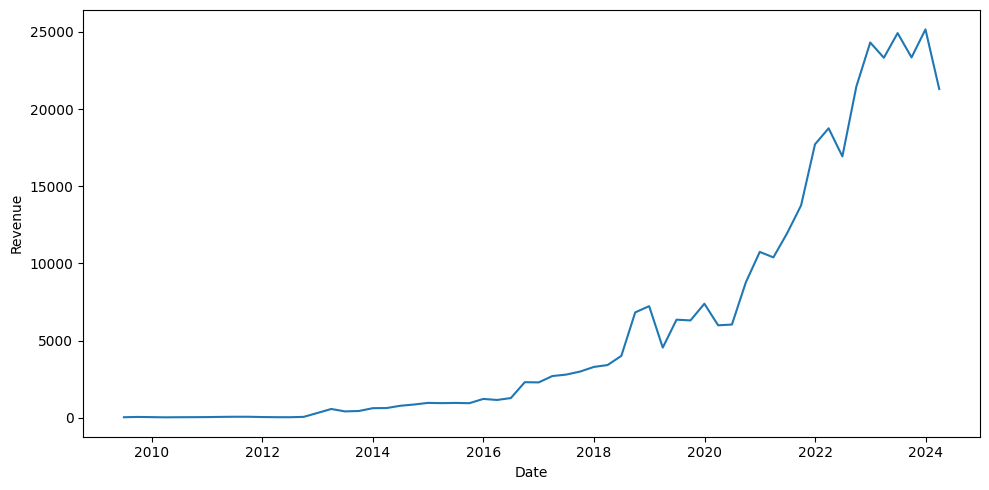

In [32]:
# Eliminar filas con valores no finitos en la columna "Revenue"
tesla_revenue = tesla_revenue.dropna(subset=["Revenue"])

# Convertir la columna "Revenue" a enteros
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype(int)


fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = tesla_revenue, x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()